In [1]:
import numpy as np
import os
from os.path import isfile
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, TimeDistributed, LSTM, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, Flatten, Conv2D, BatchNormalization, Lambda
from keras.layers.advanced_activations import ELU
from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras import backend
from keras.utils import np_utils
from keras.optimizers import Adam, RMSprop

from keras import regularizers


import librosa
import librosa.display
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
dict_genres = {'Electronic':0, 'Experimental':1, 'Folk':2, 'Hip-Hop':3, 
               'Instrumental':4,'International':5, 'Pop' :6, 'Rock': 7  }


reverse_map = {v: k for k, v in dict_genres.items()}
print(reverse_map)

{0: 'Electronic', 1: 'Experimental', 2: 'Folk', 3: 'Hip-Hop', 4: 'Instrumental', 5: 'International', 6: 'Pop', 7: 'Rock'}


In [3]:
npzfile = np.load('/content/drive/MyDrive/Colab Notebooks/shuffled_train.npz')
print(npzfile.files)
X_train = npzfile['arr_0']
y_train = npzfile['arr_1']
print(X_train.shape, y_train.shape)

['arr_0', 'arr_1']
(6394, 640, 128) (6394, 8)


In [4]:
npzfile = np.load('/content/drive/MyDrive/Colab Notebooks/shuffled_valid.npz')
print(npzfile.files)
X_valid = npzfile['arr_0']
y_valid = npzfile['arr_1']
print(X_valid.shape, y_valid.shape)

['arr_0', 'arr_1']
(800, 640, 128) (800, 8)


Pop


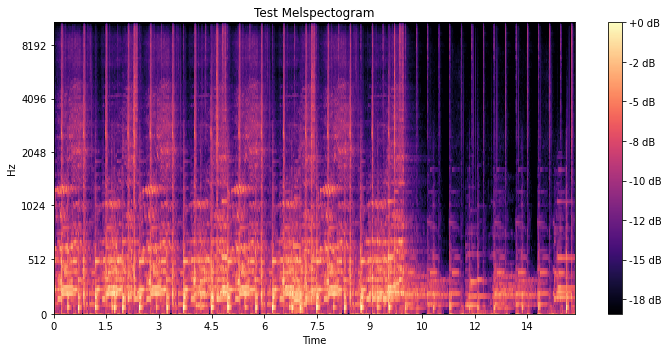

In [17]:
num = 5100
spectogram = X_train[num]
genre = np.argmax(y_train[num])
print(reverse_map[genre])
plt.figure(figsize=(10, 5))
librosa.display.specshow(spectogram.T, y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Test Melspectogram')
plt.tight_layout()

In [5]:
batch_size = 16
num_classes = 8
n_features = X_train.shape[2]
n_time = X_train.shape[1]

In [6]:
N_LAYERS = 3
FILTER_LENGTH = 5
CONV_FILTER_COUNT = 56
BATCH_SIZE = 32
LSTM_COUNT = 96
EPOCH_COUNT = 90
NUM_HIDDEN = 64
L2_regularization = 0.001

def conv_recurrent_model_build(model_input):
    print('Building model...')
    layer = model_input
    
    ### 3 1D Convolution Layers
    for i in range(N_LAYERS):
        # give name to the layers
        layer = Conv1D(
                filters=CONV_FILTER_COUNT,
                kernel_size=FILTER_LENGTH,
                kernel_regularizer=regularizers.l2(L2_regularization),  # Tried 0.001
                name='convolution_' + str(i + 1)
            )(layer)
        layer = BatchNormalization(momentum=0.9)(layer)
        layer = Activation('relu')(layer)
        layer = MaxPooling1D(2)(layer)
        layer = Dropout(0.4)(layer)
    
    ## LSTM Layer
    layer = LSTM(LSTM_COUNT, return_sequences=False)(layer)
    layer = Dropout(0.4)(layer)
    
    ## Dense Layer
    layer = Dense(NUM_HIDDEN, kernel_regularizer=regularizers.l2(L2_regularization), name='dense1')(layer)
    layer = Dropout(0.4)(layer)
    
    ## Softmax Output
    layer = Dense(num_classes)(layer)
    layer = Activation('softmax', name='output_realtime')(layer)
    model_output = layer
    model = Model(model_input, model_output)
    
    
    opt = Adam(lr=0.001)
    model.compile(
            loss='categorical_crossentropy',
            optimizer=opt,
            metrics=['accuracy']
        )
    
    print(model.summary())
    return model

In [7]:
def train_model(x_train, y_train, x_val, y_val):
    
    n_features = x_train.shape[2]
    input_shape = (None, n_features)
    model_input = Input(input_shape, name='input')
    
    model = conv_recurrent_model_build(model_input)
    
#     tb_callback = TensorBoard(log_dir='./logs/4', histogram_freq=1, batch_size=32, write_graph=True, write_grads=False,
#                               write_images=False, embeddings_freq=0, embeddings_layer_names=None,
#                               embeddings_metadata=None)
    checkpoint_callback = ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/weights.best.h5', monitor='val_accuracy', verbose=1,
                                          save_best_only=True, mode='max')
    
    reducelr_callback = ReduceLROnPlateau(
                monitor='val_accuracy', factor=0.5, patience=10, min_delta=0.01,
                verbose=1
            )
    callbacks_list = [checkpoint_callback, reducelr_callback]

    # Fit the model and get training history.
    print('Training...')
    history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCH_COUNT,
                        validation_data=(x_val, y_val), verbose=1, callbacks=callbacks_list)

    return model, history

In [8]:
def show_summary_stats(history):
    # List all data in history
    print(history.history.keys())

    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [9]:
model, history  = train_model(X_train, y_train, X_valid, y_valid)

Building model...
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, None, 128)]       0         
_________________________________________________________________
convolution_1 (Conv1D)       (None, None, 56)          35896     
_________________________________________________________________
batch_normalization (BatchNo (None, None, 56)          224       
_________________________________________________________________
activation (Activation)      (None, None, 56)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 56)          0         
_________________________________________________________________
dropout (Dropout)            (None, None, 56)          0         
_________________________________________________________________
convolution_2 (Conv1D)       (None, None, 5

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


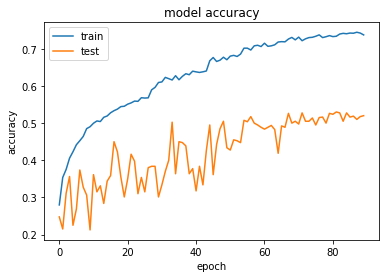

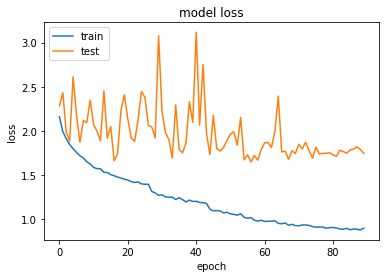

In [10]:
show_summary_stats(history)

In [11]:
from sklearn.metrics import classification_report

y_true = np.argmax(y_valid, axis = 1)
y_pred = model.predict(X_valid)
y_pred = np.argmax(y_pred, axis=1)
labels = [0,1,2,3,4,5,6,7]
target_names = dict_genres.keys()

print(y_true.shape, y_pred.shape)
print(classification_report(y_true, y_pred, target_names=target_names))

(800,) (800,)
               precision    recall  f1-score   support

   Electronic       0.47      0.46      0.47       100
 Experimental       0.41      0.57      0.48       100
         Folk       0.61      0.71      0.66       100
      Hip-Hop       0.58      0.73      0.65       100
 Instrumental       0.48      0.30      0.37       100
International       0.67      0.58      0.62       100
          Pop       0.15      0.08      0.10       100
         Rock       0.60      0.73      0.66       100

     accuracy                           0.52       800
    macro avg       0.50      0.52      0.50       800
 weighted avg       0.50      0.52      0.50       800



In [12]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_true, y_pred))

0.52


In [13]:
from keras.models import load_model

weights_path = '/content/drive/MyDrive/Colab Notebooks/weights.best.h5'
model = load_model(weights_path)

In [14]:
npzfile = np.load('/content/drive/MyDrive/Colab Notebooks/test_arr.npz')
print(npzfile.files)
X_test = npzfile['arr_0']
y_test = npzfile['arr_1']
print(X_test.shape, y_test.shape)

['arr_0', 'arr_1']
(800, 640, 128) (800,)


In [15]:
y_test -= 1
print(np.amin(y_test), np.amax(y_test), np.mean(y_test))

0 7 3.5


In [16]:
X_test_raw = librosa.core.db_to_power(X_test, ref=1.0)
print(np.amin(X_test_raw), np.amax(X_test_raw), np.mean(X_test_raw))

1e-08 1.0000000000000016 0.004623813018385694


In [17]:
X_test = np.log(X_test_raw)


from sklearn.metrics import classification_report

y_true = y_test
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
labels = [0,1,2,3,4,5,6,7]
target_names = dict_genres.keys()

print(y_true.shape, y_pred.shape)
print(classification_report(y_true, y_pred, target_names=target_names))

(800,) (800,)
               precision    recall  f1-score   support

   Electronic       0.72      0.42      0.53       100
 Experimental       0.26      0.37      0.31       100
         Folk       0.19      0.19      0.19       100
      Hip-Hop       0.61      0.79      0.69       100
 Instrumental       0.37      0.23      0.28       100
International       0.49      0.65      0.56       100
          Pop       0.35      0.30      0.32       100
         Rock       0.57      0.51      0.54       100

     accuracy                           0.43       800
    macro avg       0.45      0.43      0.43       800
 weighted avg       0.45      0.43      0.43       800



In [18]:
y_test = keras.utils.to_categorical(y_test, num_classes=8)
model.evaluate(X_test, y_test)

25/25 [==============================] - 1s 11ms/step - loss: 2.1402 - accuracy: 0.4325


[2.140172243118286, 0.4325000047683716]

In [19]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_true, y_pred))

[[42  6  7 14  6 14 10  1]
 [ 2 37  9  9 15 17  5  6]
 [ 0 47 19  0 12 10 12  0]
 [ 4  5  1 79  0  6  4  1]
 [ 3 23 32  3 23  4  4  8]
 [ 3  1 11  5  2 65  6  7]
 [ 3  6 12 18  1 14 30 16]
 [ 1 16 10  2  3  2 15 51]]


In [20]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_true, y_pred))

0.4325


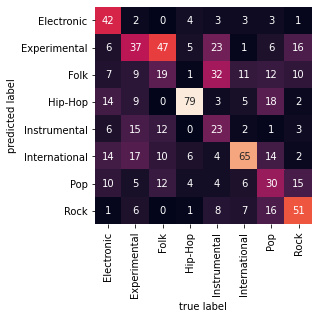

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


mat = confusion_matrix(y_true, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=dict_genres.keys(),
            yticklabels=dict_genres.keys())
plt.xlabel('true label')
plt.ylabel('predicted label');